# Some examples standard Mapper can't but Mapper can

In [ ]:
from model import Opt_GMM_Mapper
from model import Trainer

import torch
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim

import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

from gudhi.cover_complex import MapperComplex
import matplotlib.pyplot as plt
import networkx as nx

# data
import numpy as np
import matplotlib.pyplot as plt

from scripts.analysis_noise import *

torch.manual_seed(42)

In [ ]:
def sample_random_points_on_circle(radius, num_points, x_0, y_0):
    # 生成随机角度
    np.random.seed(42)

    theta = np.random.uniform(0, 2 * np.pi, num_points)
    x = radius * np.cos(theta) + x_0
    y = radius * np.sin(theta) + y_0
    
    return np.column_stack((x, y))

100%|██████████| 300/300 [00:13<00:00, 21.46it/s]


loss: -0.1554315085397926
topo_loss: -1.2348058112525884
mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


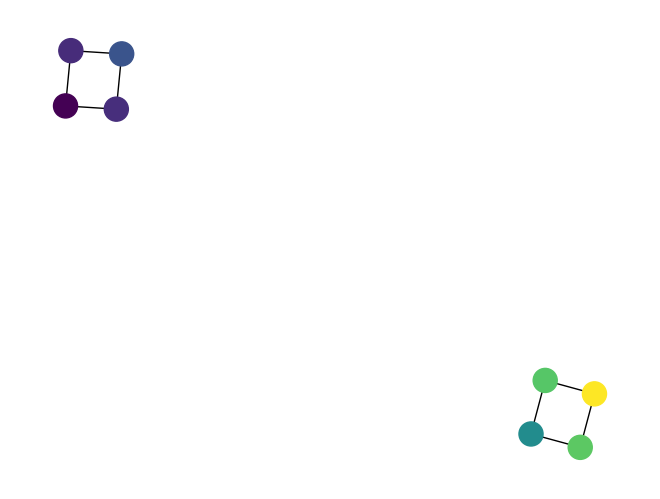

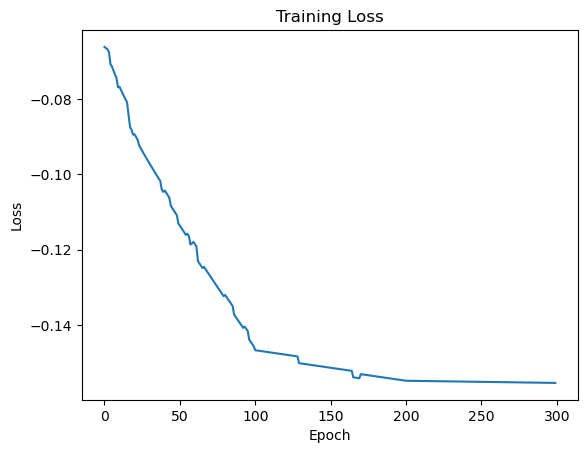

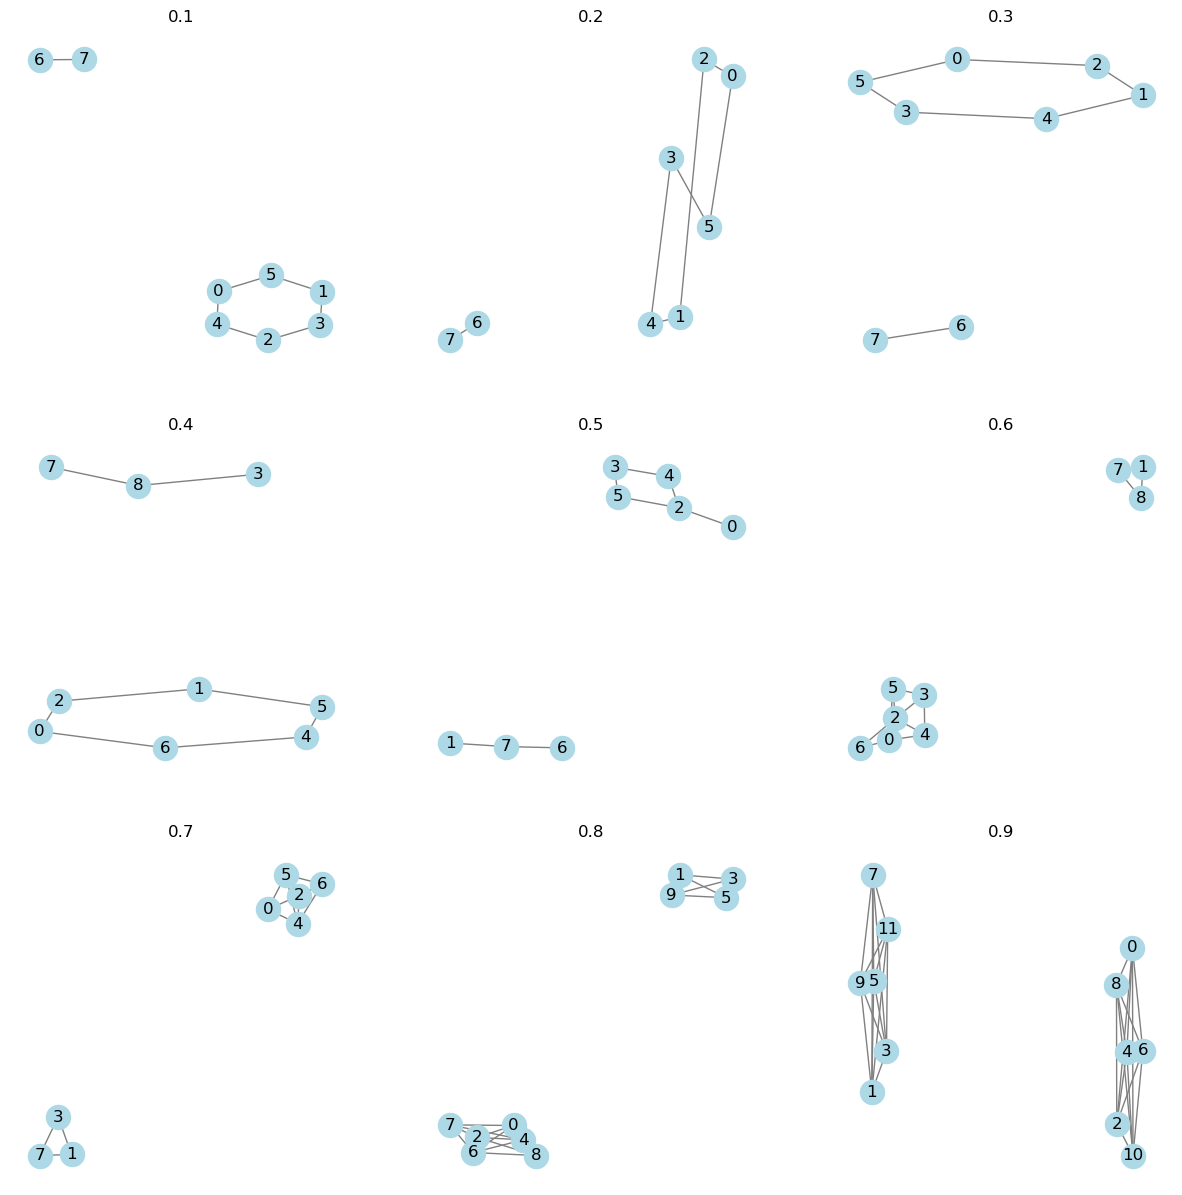

tensor(0.4022, dtype=torch.float64)


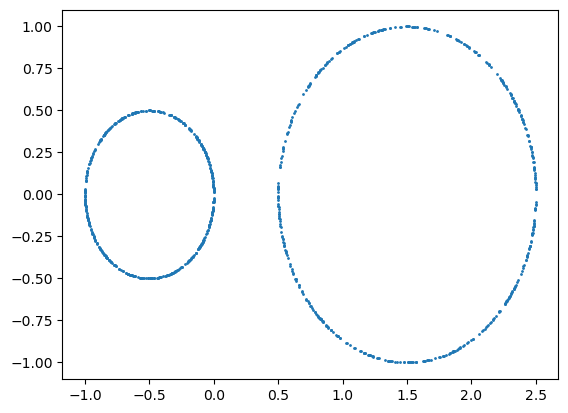

In [3]:
# data
c1 = sample_random_points_on_circle(1, 500, 1.5, 0)
c2 = sample_random_points_on_circle(0.5, 500, -0.5, 0)

data_2c = np.row_stack((c1, c2))
data = torch.tensor(data_2c)

projected_data = data[:,0]
projected_data = projected_data.view(len(data), 1)

# init parameters
n_comp = 6
num_step = 300
l1 = 1 
l2 = 1 #0.6

# GMM initialization
gmm = GaussianMixture(n_components=n_comp, covariance_type='full', n_init = 10,
                      max_iter= 1000,tol=1e-6,random_state = 0 )
gmm.fit(projected_data)
init_mean = torch.tensor(gmm.means_).view(-1)
init_var = torch.tensor(gmm.covariances_).view(-1)
init_weights = torch.tensor(gmm.weights_).view(-1)
db = DBSCAN(eps=0.3,  min_samples=5)
m = Opt_GMM_Mapper(n_comp, means = init_mean, covariances=init_var, weights=init_weights)
init_scheme = m.forward(projected_data, data, db)

# mapper before optimization
before_list_2c = m.mode_filtration_f.detach().numpy()
se_list_before_2c = get_intervals(m.mode_assignments, projected_data)
G_mode_before_2c = m.get_mode_graph()

# define optimizer and scheduler
optimizer = optim.SGD(m.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

# train
train = Trainer(m, db, num_step, optimizer, scheduler)
train.fit(data, projected_data, l1, l2)
# train.analysis()

# loss plot
plt.plot(train.losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.savefig('figures/extra1_loss.eps', bbox_inches='tight')
plt.show()

# mapper after optimization
after_list_2c = m.mode_filtration_f.detach().numpy()
se_list_after_2c = get_intervals(m.mode_assignments, projected_data)
G_mode_after_2c = m.get_mode_graph()

# standard Mapper

get_all_Mapper(data, projected_data, n_comp, db)
mapper_2c = MapperComplex(
resolutions=n_comp,
gains=0.1,
clustering=db,
)
mapper_2c.fit(data, filters=projected_data.numpy(),colors=projected_data.numpy())
se_list_regular_2c = get_regular_intervals([projected_data.min(),projected_data.max()], n_comp, 0.33)
G_2c = mapper_2c.get_networkx()

plt.scatter(data[:,0], data[:,1],s=1)
plt.show()

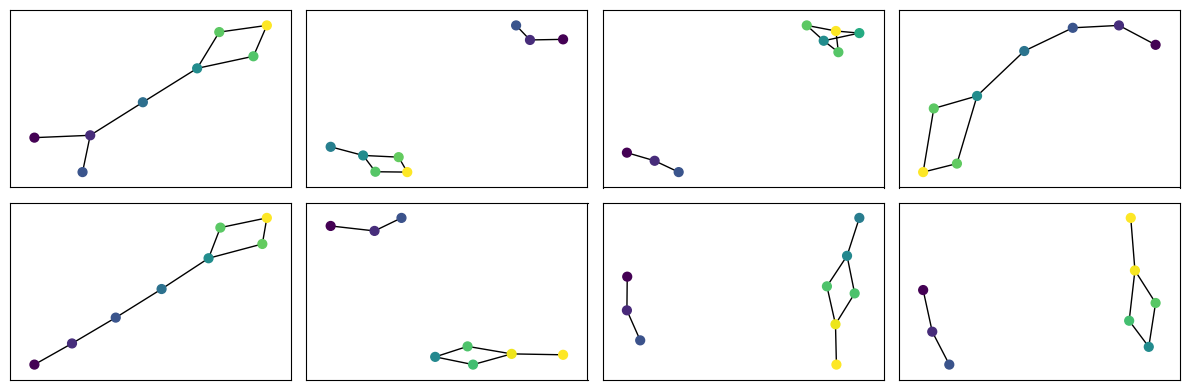

In [4]:
G_list = m.sample(8, train.scheme)

plt.figure(figsize=(12, 4))
for i, G in enumerate(G_list):
    ax = plt.subplot(2, 4, i+1)  
    pos = nx.spring_layout(G)  
    filtration_k = m.sample_filtration[i]
    filtration_k = filtration_k[~torch.isnan(filtration_k)]

    nx.draw_networkx(G, pos, with_labels=False,node_color = filtration_k,node_size = 40)
    ax.set_xticks([]) 
    ax.set_yticks([])  

plt.tight_layout()
plt.savefig('figures/2c_extra.eps', bbox_inches='tight')

100%|██████████| 400/400 [00:14<00:00, 27.02it/s]


loss: -0.8176106953695381
topo_loss: -1.867059059572947
mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


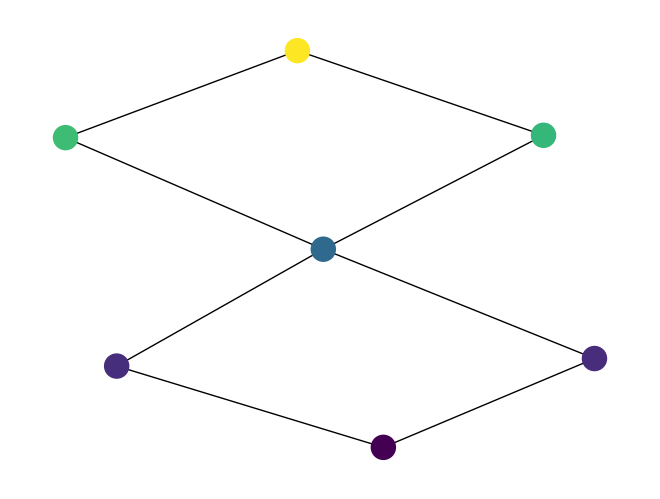

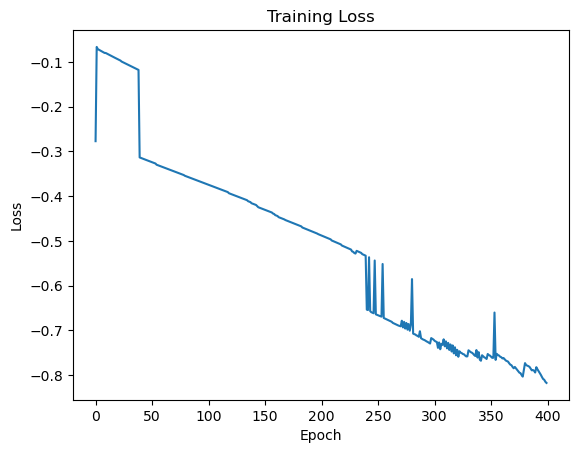

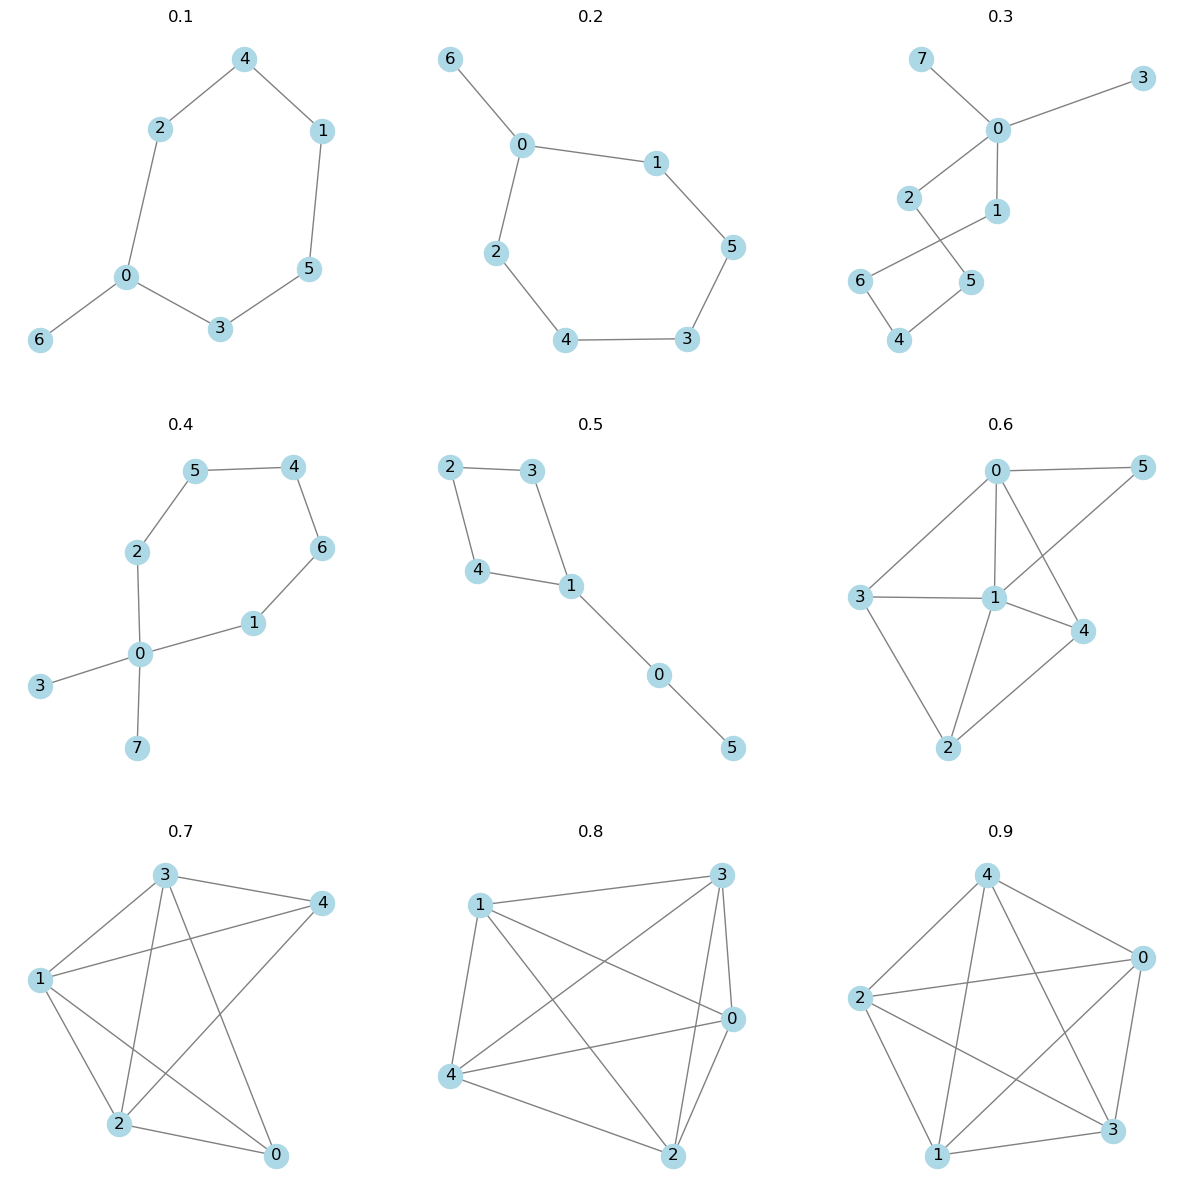

tensor(0.3273, dtype=torch.float64)


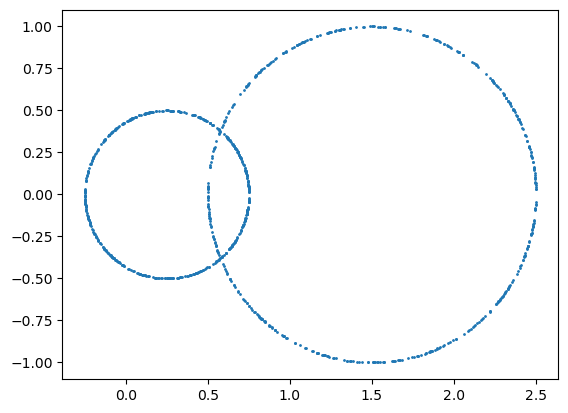

In [5]:
# data
c1 = sample_random_points_on_circle(1, 500, 1.5, 0)
c2 = sample_random_points_on_circle(0.5, 500, 0.25, 0)

data_2ic = np.row_stack((c1, c2))
data = torch.tensor(data_2ic)
projected_data = data[:,0]
projected_data = projected_data.view(len(data), 1)

# init
n_comp = 5 # 6
num_step = 400
l1 = 1
l2 = 1 

# GMM initialization
gmm = GaussianMixture(n_components=n_comp, covariance_type='full', n_init = 100,
                      max_iter= 1000,tol=1e-6
                      ,random_state = 0 )
gmm.fit(projected_data)
init_mean = torch.tensor(gmm.means_).view(-1)
init_var = torch.tensor(gmm.covariances_).view(-1)
init_weights = torch.tensor(gmm.weights_).view(-1)
db = DBSCAN(eps=0.2,  min_samples=5)
m = Opt_GMM_Mapper(n_comp, means = init_mean, covariances=init_var, weights=init_weights)
init_scheme = m.forward(projected_data, data, db)

# mapper before optimization
before_list_2ic = m.mode_filtration_f.detach().numpy()
se_list_before_2ic = get_intervals(m.mode_assignments, projected_data)
G_mode_before_2ic = m.get_mode_graph()

# define optimizer and scheduler
optimizer = optim.SGD(m.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=400, gamma=0.01)

# train
train = Trainer(m, db, num_step, optimizer, scheduler)
train.fit(data, projected_data, l1, l2)
# train.analysis()

# loss plot
plt.plot(train.losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.savefig('figures/extra2_loss.eps', bbox_inches='tight')
plt.show()

# mapper after optimization
after_list_2ic = m.mode_filtration_f.detach().numpy()
se_list_after_2ic = get_intervals(m.mode_assignments, projected_data)
G_mode_after_2ic = m.get_mode_graph()

get_all_Mapper(data, projected_data, n_comp, db)
mapper_2ic = MapperComplex(
resolutions=n_comp,
gains=0.2,
clustering=db,
)
mapper_2ic.fit(data, filters=projected_data.numpy(),colors=projected_data.numpy())
se_list_regular_2ic = get_regular_intervals([projected_data.min(),projected_data.max()], n_comp, 0.2)
G_2ic = mapper_2ic.get_networkx()

plt.scatter(data[:,0], data[:,1],s=1)
plt.show()

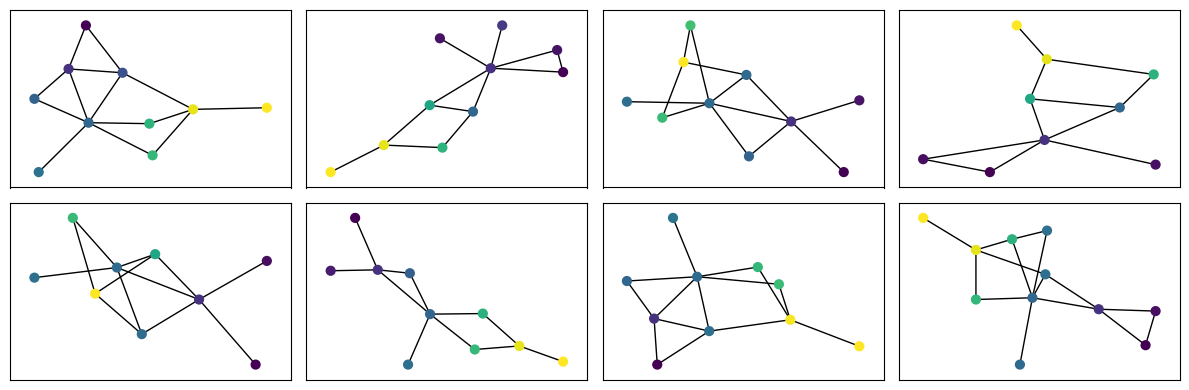

In [6]:
G_list = m.sample(8, train.scheme)

plt.figure(figsize=(12, 4))
for i, G in enumerate(G_list):
    ax = plt.subplot(2, 4, i+1)  
    pos = nx.spring_layout(G)  
    filtration_k = m.sample_filtration[i]
    filtration_k = filtration_k[~torch.isnan(filtration_k)]

    nx.draw_networkx(G, pos, with_labels=False,node_color = filtration_k,node_size = 40)
    ax.set_xticks([]) 
    ax.set_yticks([])  

plt.tight_layout()
plt.savefig('figures/2ic_extra.eps', bbox_inches='tight')

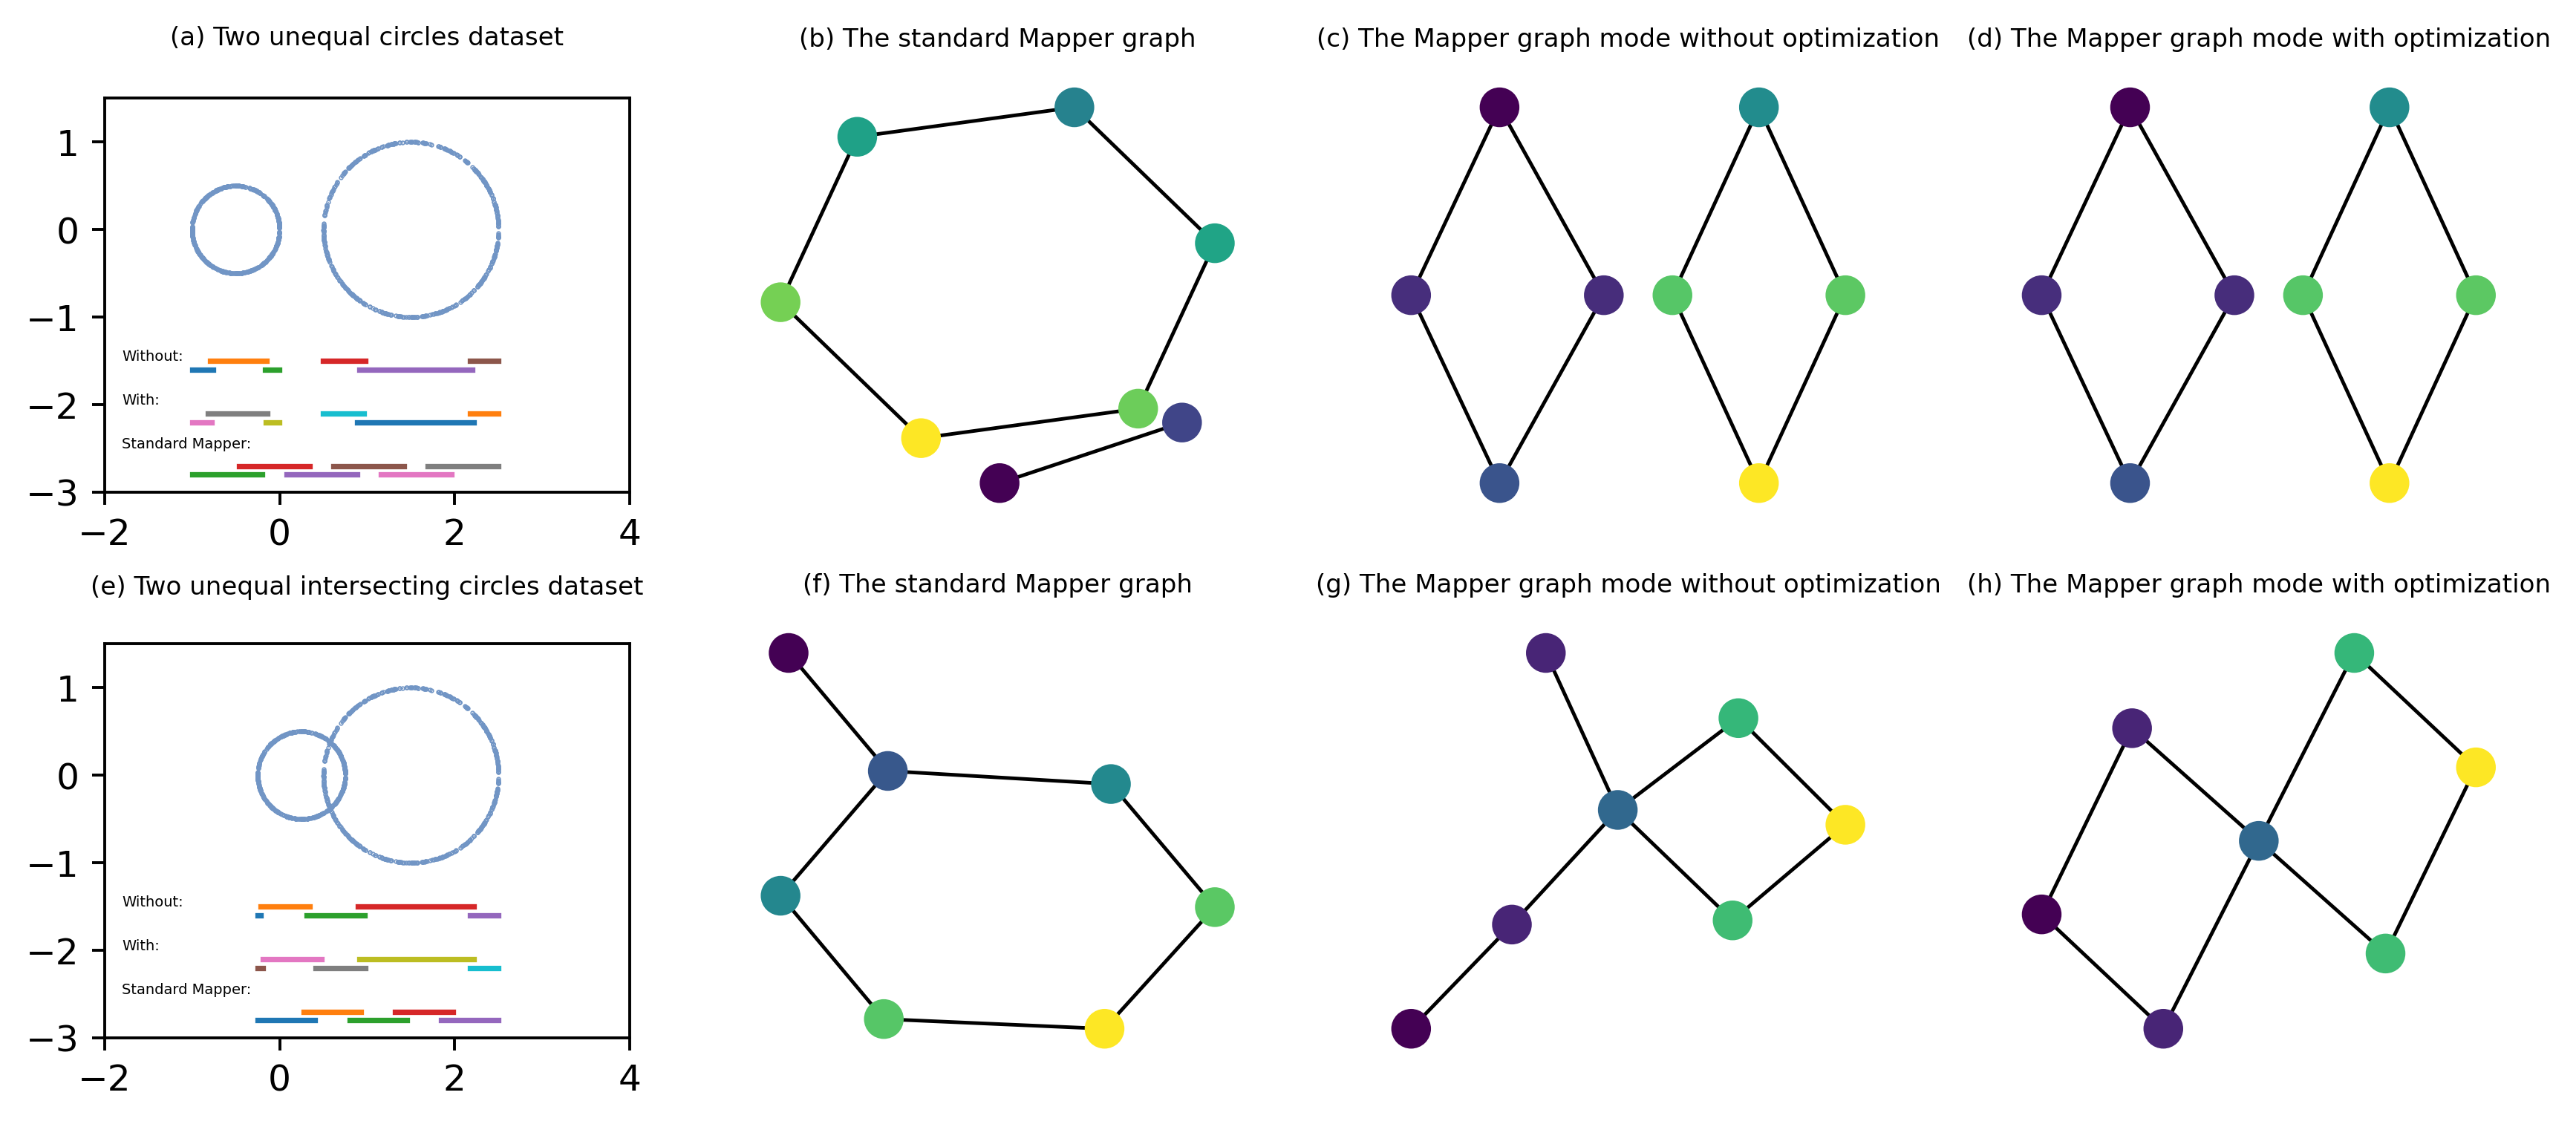

In [7]:
G_2c
G_mode_before_2c
G_mode_after_2c
before_list_2c
se_list_before_2c
after_list_2c
se_list_after_2c


G_2ic
G_mode_before_2ic
G_mode_after_2ic
before_list_2ic
se_list_before_2ic
after_list_2ic
se_list_after_2ic

n_size = 100 # node size 

fig, axs = plt.subplots(2, 4) 
fig.set_size_inches(12, 5)  
fig.dpi = 350  

axs[0, 0].scatter(data_2c[:,0],data_2c[:,1],s=0.1,c='#7195c5')
axs[0, 0].set_xlim((-2, 4))
axs[0, 0].set_ylim((-3, 1.5))
axs[0, 0].set_aspect('equal', adjustable='box')

for i,se in enumerate(se_list_before_2c):
    s,e = se[0], se[1]
    axs[0, 0].plot([s,e],[0.1*(i % 2)-1.6,0.1*(i % 2)-1.6])

for i,se in enumerate(se_list_after_2c):
    s,e = se[0], se[1]
    axs[0, 0].plot([s,e],[0.1*(i % 2)-2.2,0.1*(i % 2)-2.2])

for i,se in enumerate(se_list_regular_2c):
    s,e = se[0], se[1]
    axs[0, 0].plot([s,e],[0.1*(i % 2)-2.8,0.1*(i % 2)-2.8])

axs[0, 0].text(-1.8, -1.5, 'Without:', fontsize=4) 
axs[0, 0].text(-1.8, -2, 'With:', fontsize=4) 
axs[0, 0].text(-1.8, -2.5, 'Standard Mapper:', fontsize=4) 

nx.draw(G_2c, pos = nx.kamada_kawai_layout(G_2c), 
        node_color=[mapper_2c.node_info_[v]["colors"][0] for v in G_2c.nodes()], 
        ax=axs[0, 1], node_size=n_size)

pos = {3: np.array([0.1,  0.9 ]), 2: np.array([0.3 , 0.9]), 1: np.array([ 0.02063238, 0.9]), 
       0: np.array([-0.20223454, 0.9]), 6: np.array([-0.1, 0.8]), 5: np.array([0.2, 1.        ]), 
       4: np.array([0.2, 0.8]), 7: np.array([-0.1, 1])}

nx.draw(G_mode_before_2c, pos = pos,
        node_color=before_list_2c,
        ax=axs[0, 2], node_size=n_size)

nx.draw(G_mode_after_2c, pos = pos,
        node_color=before_list_2c,
        ax=axs[0, 3], node_size=n_size)

# 2ic
axs[1, 0].scatter(data_2ic[:,0],data_2ic[:,1],s=0.1,c='#7195c5')
axs[1, 0].set_xlim((-2, 4))
axs[1, 0].set_ylim((-3, 1.5))
axs[1, 0].set_aspect('equal', adjustable='box')

for i,se in enumerate(se_list_before_2ic):
    s,e = se[0], se[1]
    axs[1, 0].plot([s,e],[0.1*(i % 2)-1.6,0.1*(i % 2)-1.6])

for i,se in enumerate(se_list_after_2ic):
    s,e = se[0], se[1]
    axs[1, 0].plot([s,e],[0.1*(i % 2)-2.2, 0.1*(i % 2)-2.2])

for i,se in enumerate(se_list_regular_2ic):
    s,e = se[0], se[1]
    axs[1, 0].plot([s,e],[0.1*(i % 2)-2.8,0.1*(i % 2)-2.8])

axs[1, 0].text(-1.8, -1.5, 'Without:', fontsize=4) 
axs[1, 0].text(-1.8, -2, 'With:', fontsize=4) 
axs[1, 0].text(-1.8, -2.5, 'Standard Mapper:', fontsize=4) 


nx.draw(G_2ic, pos = nx.kamada_kawai_layout(G_2ic), 
        node_color=[mapper_2ic.node_info_[v]["colors"][0] for v in G_2ic.nodes()], 
        ax=axs[1, 1], node_size=n_size)


nx.draw(G_mode_before_2ic, pos = nx.kamada_kawai_layout(G_mode_before_2ic),
        node_color=before_list_2ic,
        ax=axs[1, 2], node_size=n_size)

nx.draw(G_mode_after_2ic, pos = nx.kamada_kawai_layout(G_mode_after_2ic), #nx.spring_layout(G_mode_after_2ic)
        node_color=before_list_2ic,
        ax=axs[1, 3], node_size=n_size)

title_y = 1.0
title_fontsize = 7
axs[0, 0].set_title('(a) Two unequal circles dataset', y=1.08, fontsize=title_fontsize)
axs[0, 1].set_title('(b) The standard Mapper graph', y=title_y, fontsize=title_fontsize)
axs[0, 2].set_title('(c) The Mapper graph mode without optimization', y=title_y, fontsize=title_fontsize)
axs[0, 3].set_title('(d) The Mapper graph mode with optimization', y=title_y, fontsize=title_fontsize)
axs[1, 0].set_title('(e) Two unequal intersecting circles dataset', y=1.07, fontsize=title_fontsize)
axs[1, 1].set_title('(f) The standard Mapper graph', y=title_y, fontsize=title_fontsize)
axs[1, 2].set_title('(g) The Mapper graph mode without optimization', y=title_y, fontsize=title_fontsize)
axs[1, 3].set_title('(h) The Mapper graph mode with optimization', y=title_y, fontsize=title_fontsize)

plt.savefig("figures/ex2_all.eps", bbox_inches='tight')